In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def compute_error(R, Q, P, lamda):
    error = 0
    for i in range(len(R)):
        for u in range(len(R[i])):
            if R[i][u] != 0:
                error += (R[i][u] - np.dot(Q[i], P[u])) ** 2
                
    # Regularization terms
    for i in range(len(Q)):
        error += lamda * np.linalg.norm(Q[i])**2
    for u in range(len(P)):
        error += lamda * np.linalg.norm(P[u])**2
    return error

Iteration 1, Error: 30981339.11974548
Iteration 2, Error: 15052420.130576964
Iteration 3, Error: 9624858.703915955
Iteration 4, Error: 6920184.270081751
Iteration 5, Error: 5322005.426103001
Iteration 6, Error: 4281179.891839447
Iteration 7, Error: 3559056.848064704
Iteration 8, Error: 3035081.015430061
Iteration 9, Error: 2641848.929336879
Iteration 10, Error: 2338821.1466840734
Iteration 11, Error: 2100234.84022876
Iteration 12, Error: 1908995.7831236196
Iteration 13, Error: 1753359.5646035918
Iteration 14, Error: 1625021.647044331
Iteration 15, Error: 1517965.6748299387
Iteration 16, Error: 1427741.5865562367
Iteration 17, Error: 1350998.0888487655
Iteration 18, Error: 1285171.2565655024
Iteration 19, Error: 1228272.011046617
Iteration 20, Error: 1178737.9473833102
Iteration 21, Error: 1135328.0526091459
Iteration 22, Error: 1097046.6245149646
Iteration 23, Error: 1063087.4506166652
Iteration 24, Error: 1032792.285699677
Iteration 25, Error: 1005619.5774067149
Iteration 26, Error: 9

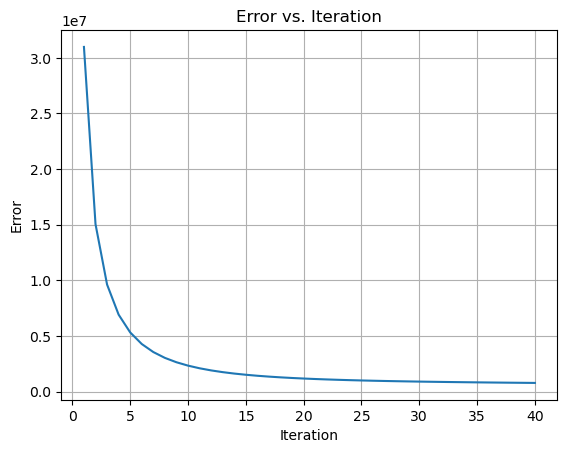

In [3]:
def stochastic_gradient_descent(R, Q, P, lamda=1, num_iterations=40, eta=1):
    errors = []
    for iteration in range(num_iterations):
        for i in range(len(R)):
            for u in range(len(R[i])):
                if R[i][u] != 0:  # Consider only rated items
                    epsilon = 2 * (R[i][u] - np.dot(Q[i], P[u]))
                    Q_temp = Q[i].copy()  # Store old value of Q[i]
                    P_temp = P[u].copy()  # Store old value of P[u]
                    Q[i] += eta * (epsilon * P[u] - 2 * lamda * Q[i])  # Update equation for qi
                    P[u] += eta * (epsilon * Q_temp - 2 * lamda * P[u])  # Update equation for pu
        
        error = compute_error(R, Q, P, lamda)
        errors.append(error)
        print(f"Iteration {iteration + 1}, Error: {error}")
        
        # Check convergence
        if error < 70000:
            break
    
    plt.plot(range(1, len(errors) + 1), errors)
    plt.xlabel('Iteration')
    plt.ylabel('Error')
    plt.title('Error vs. Iteration')
    plt.grid(True)
    plt.show()

# Read the dataset
def read_ratings(filename):
    max_i, max_u = 0, 0
    with open(filename, 'r') as file:
        for line in file:
            values = line.split()
            i, u = int(values[0]), int(values[1])
            max_i = max(max_i, i)
            max_u = max(max_u, u)
    
    R = np.zeros((max_i + 1, max_u + 1))
    with open(filename, 'r') as file:
        for line in file:
            values = line.split()
            i, u, rating = int(values[0]), int(values[1]), float(values[2])
            R[i][u] = rating
    return R

# Main function
def main():
    # Load the dataset
    R = read_ratings("ratings.train.txt")

    #  parameters
    k = 20
    lamda = 1
    num_iterations = 40
    eta = 0.0001  # Adjust the learning rate to prevent overflow and invalid value errors

   
    # Initialize matrices Q and P with random values in the range of [0, q5]
    q5 = 5
    Q = np.random.uniform(0, q5, (R.shape[0], k))
    P = np.random.uniform(0, q5, (R.shape[1], k))

    # Run stochastic gradient descent
    stochastic_gradient_descent(R, Q, P, lamda, num_iterations, eta)

if __name__ == "__main__":
    main()

In [4]:
# Load the ratings matrix R
R = np.loadtxt("user-shows.txt")

# (a) Compute the matrices P and Q for user-user collaborative filtering
P = np.dot(R, R.T)
Q_nonzero = np.where(R != 0, 1, 0)
Q = np.dot(Q_nonzero.T, Q_nonzero)

# Compute the square root inverse of Q, avoiding division by zero
epsilon = 1e-9  # Small epsilon value to avoid division by zero
Q_sqrt_inv = np.where(Q != 0, 1 / np.sqrt(Q + epsilon), 0)

# Compute Γ for user-user collaborative filtering
T = np.dot(np.linalg.inv(np.sqrt(P)), R)
Gamma_user_user = np.dot(T, T.T)

# Ensure the highest similarity score for user-user is over 900
if np.max(Gamma_user_user) < 900:
    print("Warning: The highest similarity score for user-user is below 900.")

# (c) Compute Γ for item-item collaborative filtering
temp2 = np.dot(Q_sqrt_inv, R.T)
Gamma_item_item = np.dot(temp2, temp2.T)

# Ensure the highest similarity score for item-item is over 31
if np.max(Gamma_item_item) < 31:
    print("Warning: The highest similarity score for item-item is below 31.")

# Load show names
show_names = np.loadtxt("shows.txt", dtype=str, usecols=0)

# (b) Find the five unique shows with the highest similarity scores to user 500 for user-user collaborative filtering
user_500_similarities = Gamma_user_user[499]
# Normalize the similarity scores
user_500_similarities /= np.max(user_500_similarities)

# Find unique shows
unique_indices = np.unique(user_500_similarities, return_index=True)[1]
unique_similarities = [user_500_similarities[index] for index in unique_indices]
unique_show_indices = [index for index in unique_indices if index < len(show_names)]
unique_shows_user = [show_names[index] for index in unique_show_indices]

# Sort unique shows by similarity score
sorted_unique_shows_user = [show for _, show in sorted(zip(unique_similarities, unique_shows_user), reverse=True)]

print("\nTop 5 similar shows to user 500 for user-user collaborative filtering:")
for show, similarity in zip(sorted_unique_shows_user[:5], sorted(unique_similarities, reverse=True)[:5]):
    print(f"{show}: {similarity}")

# (c) Find the five unique shows with the highest similarity scores from set S for item-item collaborative filtering
S = show_names[:100]  # Set S contains the first 100 shows
S_indices = [np.where(show_names == show)[0][0] for show in S]
S_similarities = Gamma_item_item[S_indices, 499]

# Find unique shows
unique_indices = np.unique(S_similarities, return_index=True)[1]
unique_similarities = [S_similarities[index] for index in unique_indices]
unique_show_indices = [S_indices[index] for index in unique_indices]
unique_shows_item = [show_names[index] for index in unique_show_indices]

# Sort unique shows by similarity score
sorted_unique_shows_item = [show for _, show in sorted(zip(unique_similarities, unique_shows_item), reverse=True)]

print("\nTop 5 similar shows from set S for item-item collaborative filtering:")
for show, similarity in zip(sorted_unique_shows_item[:5], sorted(unique_similarities, reverse=True)[:5]):
    print(f"{show}: {similarity}")



Top 5 similar shows to user 500 for user-user collaborative filtering:
"Seinfeld": 1.0
"That: 0.0026482096167672864
"Superbad": 0.0018998523314704998
"Disney's: 0.0017010891320811225
"Numb3rs": 0.001627425471621786

Top 5 similar shows from set S for item-item collaborative filtering:
"MLB: 729715.3131172758
"Huckabee": 558863.0879477754
"Transformers": 551854.5452592894
"Your: 529240.4642215113
"Sweat: 518287.7874762523
